In [1]:
import sys
sys.path.append('../')
import systemsounds as ss
import numpy as np
import rebound
from midiutil import MIDIFile
from subprocess import call
import matplotlib.pyplot as plt
from rebound.plotting import fading_line
from scipy.misc import imread
from exoplanets import make_sim
import pandas as pd
%matplotlib inline

# Getting a Feel for Things

In [2]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1.)

In [3]:
sim.getWidget()

Widget(N=2, count=2, height=200.0, orbit_data=b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', orbits=True, orientation=(0.0, 0.0, 0.0, 1.0), overlay='REBOUND (ias15), N=2, t=0', particle_data=b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00\x00\x00\x00\x00\x00', scale=1.1, width=200.0)

In [4]:
sim.usleep = 1.e5
sim.integrate(20.)

In [5]:
sim.particles[1].P

6.2831853071795845

# Making Music

# Step 1: Rescale Units

In [6]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1.)

# Step 2: Record Events

In [7]:
transits = ss.EventRecorder(sim, lambda sim, i: sim.particles[i].y)

In [8]:
sim.usleep = 0
ss.rescale_time(sim, sim.particles[1].P)
sim.integrate(6)

In [9]:
transits.events[0]

{'target': 1, 'time': 1.0000004407921361, 'verbose': False}

# Step 3: Make a MIDI File!

In [10]:
bpm = 60
midifile = MIDIFile()
midifile.addTempo(track=0, time=0, tempo=bpm) 

In [11]:
for transit in transits.events:
    midifile.addNote(track=0, channel=0, pitch=48, time=transit['time'], duration=1, volume=100)

In [12]:
with open("./stao.mid", "wb") as f:
    midifile.writeFile(f)
call("timidity ./stao.mid", shell=True)

0

# Making a Movie

# Step 1: Adding Frame Events

In [13]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1.)
transits = ss.EventRecorder(sim, lambda sim, i: sim.particles[i].y)

In [14]:
frames = ss.FrameRecorder(sim, time_per_sec=bpm/60.)
ss.rescale_time(sim, sim.particles[1].P)
sim.integrate(5)

In [15]:
len(frames.events)

149

In [16]:
frames.events[0]

{'elapsed_time': 0.03709839620236269,
 'filename': 'tmp/binaries/frame0.bin',
 'fps': 30,
 'frame_ctr': 0,
 'plotparticles': range(1, 2),
 'target': None,
 'time': 0.0333333451703471,
 'time_per_sec': 1.0,
 'verbose': False}

# Step 2: Write a Function to Make a Frame

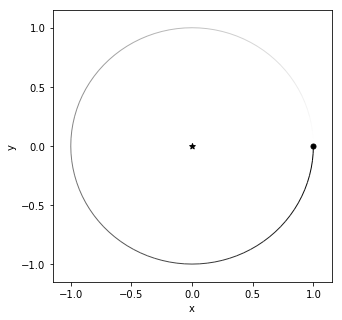

In [17]:
fig = rebound.OrbitPlot(sim)

In [18]:
def write_png(params):
    sim = rebound.Simulation.from_file(params['filename'])
    fig = rebound.OrbitPlot(sim)
    fig.savefig('tmp/pngs/{0:0=5d}.png'.format(params['frame_ctr']))
    plt.close(fig)

# Step 3: Write Frames

In [19]:
%%time
from subprocess import call
call("rm -f tmp/pngs/*", shell=True)
pool = rebound.InterruptiblePool()
res = pool.map(write_png, frames.events)

CPU times: user 11 ms, sys: 19.1 ms, total: 30.1 ms
Wall time: 6.39 s


# Step 4: Make a Movie

In [20]:
# remove temporary files
call("rm -f test.mp4", shell=True)
call("rm -f tmp/test.wav", shell=True)
call("rm -f tmp/testcut.wav", shell=True)

# make movie
call("timidity -Ow stao.mid -o tmp/test.wav --preserve-silence", shell=True)
call("ffmpeg -t {0} -i tmp/test.wav tmp/testcut.wav".format(frames.elapsed_time), shell=True)
call("ffmpeg -r 30 -i tmp/pngs/%05d.png -i tmp/testcut.wav -c:v libx264 -pix_fmt yuv420p -c:a libfdk_aac -b:a 192k -shortest test.mp4", shell=True)
call("open test.mp4", shell=True)

0

# Stepping it Up

In [2]:
df = pd.read_csv("../planets.csv", header=386, index_col=0, skip_blank_lines=True)
df.tail()

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,...,st_bmyblend,st_m1,st_m1err,st_m1lim,st_m1blend,st_c1,st_c1err,st_c1lim,st_c1blend,st_colorn
rowid,,,,,,,,,,,,,,,,,,,,,
3427,tau Gem,b,Radial Velocity,1,305.500000,0.100000,-0.100000,0.0,1.170000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3428,ups And,b,Radial Velocity,3,4.617033,0.000023,-0.000023,0.0,0.059222,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3429,ups And,c,Radial Velocity,3,241.258000,0.064000,-0.064000,0.0,0.827774,0.000015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3430,ups And,d,Radial Velocity,3,1276.460000,0.570000,-0.570000,0.0,2.513290,0.000750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3431,xi Aql,b,Radial Velocity,1,136.750000,0.250000,-0.250000,0.0,0.680000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


# 4 planet systems

In [3]:
df[df['pl_pnum'] == 4]

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,...,st_bmyblend,st_m1,st_m1err,st_m1lim,st_m1blend,st_c1,st_c1err,st_c1lim,st_c1blend,st_colorn
rowid,,,,,,,,,,,,,,,,,,,,,
129,GJ 676 A,b,Radial Velocity,4,1051.100000,0.400000,-0.400000,0.0,1.812000,0.002000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
130,GJ 676 A,c,Radial Velocity,4,7337.000000,95.000000,-92.000000,0.0,6.600000,0.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
131,GJ 676 A,d,Radial Velocity,4,3.600500,0.000200,-0.000200,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
132,GJ 676 A,e,Radial Velocity,4,35.390000,0.030000,-0.040000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
138,GJ 876,b,Radial Velocity,4,61.116600,0.008600,-0.008600,0.0,0.208317,0.000020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
139,GJ 876,c,Radial Velocity,4,30.088100,0.008200,-0.008200,0.0,0.129590,0.000024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
140,GJ 876,d,Radial Velocity,4,1.937780,0.000020,-0.000020,0.0,0.020807,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
141,GJ 876,e,Radial Velocity,4,124.260000,0.700000,-0.700000,0.0,0.334300,0.001300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
325,HD 141399,b,Radial Velocity,4,94.440000,0.050000,-0.050000,0.0,0.415000,0.011000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


# Planets that go around their star in less than a day!

In [4]:
df[df['pl_orbper'] < 1]

,pl_hostname,pl_letter,pl_discmethod,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,...,st_bmyblend,st_m1,st_m1err,st_m1lim,st_m1blend,st_c1,st_c1err,st_c1lim,st_c1blend,st_colorn
rowid,,,,,,,,,,,,,,,,,,,,,
28,55 Cnc,e,Radial Velocity,5,0.736539,7.000000e-06,-7.000000e-06,0.0,0.015440,0.00009,...,0.0,0.357,0.004,0.0,0.0,0.415,0.005,0.0,0.0,11
87,CoRoT-7,b,Transit,2,0.853592,5.700000e-07,-5.700000e-07,0.0,0.017016,0.00017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
213,HATS-18,b,Transit,1,0.837843,4.700000e-07,-4.700000e-07,0.0,0.017610,0.00027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
529,HD 3167,b,Transit,2,0.959628,1.200000e-05,-1.200000e-05,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
728,K2-22,b,Transit,1,0.381078,1.000000e-06,-1.000000e-06,0.0,0.008800,0.00080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
816,K2-85,b,Transit,1,0.684533,1.800000e-05,-1.800000e-05,0.0,0.012630,0.00037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
825,K2-92,b,Transit,1,0.701818,7.100000e-05,-7.100000e-05,0.0,0.015660,0.00020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
840,KIC 10001893,b,Orbital Brightness Modulation,3,0.219700,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
841,KIC 10001893,c,Orbital Brightness Modulation,3,0.325280,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


# Kepler 223

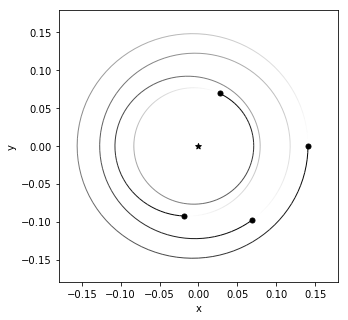

In [5]:
sim = make_sim(df, 'Kepler-223')
fig = rebound.OrbitPlot(sim)

# Special Period Ratios

In [6]:
ps = sim.particles
print(ps[2].P/ps[1].P, ps[3].P/ps[2].P, ps[4].P/ps[3].P)

1.333286388091792 1.5020547166055234 1.3338348427075029


# Some Nicer Frames

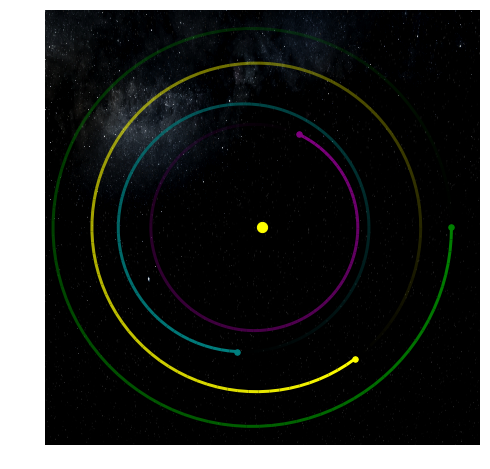

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
ps = sim.particles
star = ps[0]

# set plot boundaries to larger than outermost planet
lim = 1.15*ps[-1].a
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
fig.axes[0].axis('off') # turn off axes

colors = ["purple", "teal", "yellow", "green"]
linewidth=3.

ax.scatter(star.x, star.y, s=35*linewidth, facecolor="yellow", zorder=3)
for i, p in enumerate(ps[1:]):
    ax.scatter(p.x, p.y, s=10*linewidth, facecolor=colors[i], zorder=3)

    #plot orbit
    o = np.array(p.sample_orbit())
    lc = fading_line(o[:,0], o[:,1], color=colors[i], linewidth=linewidth)
    ax.add_collection(lc)

bkg = imread('../images/US_background_image.png')
ax.imshow(bkg, zorder=0, extent=ax.get_xlim()+ax.get_ylim())

In [40]:
def write_png(params):
    sim = rebound.Simulation.from_file(params['filename'])
    ps = sim.particles
    fig, ax = plt.subplots(figsize=(8,8))
    star = ps[0]

    # set plot boundaries to larger than outermost planet
    lim = 1.15*ps[-1].a
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    fig.axes[0].axis('off') # turn off axes

    colors = ["purple", "teal", "yellow", "green"]
    linewidth=3.

    ax.scatter(star.x, star.y, s=35*linewidth, facecolor="yellow", zorder=3)
    for i, p in enumerate(ps[1:]):
        ax.scatter(p.x, p.y, s=10*linewidth, facecolor=colors[i], zorder=3)

        #plot orbit
        o = np.array(p.sample_orbit())
        lc = fading_line(o[:,0], o[:,1], color=colors[i], linewidth=linewidth)
        ax.add_collection(lc)

    bkg = imread('../images/US_background_image.png')
    ax.imshow(bkg, zorder=0, extent=ax.get_xlim()+ax.get_ylim())
    fig.savefig('tmp/pngs/{0:0=5d}.png'.format(params['frame_ctr']))
    plt.close(fig)

In [48]:
sim = make_sim(df, 'Kepler-223')
bpm = 30
ss.rescale_time(sim, sim.particles[-1].P)
transits = ss.EventRecorder(sim, lambda sim, i: sim.particles[i].y)
frames = ss.FrameRecorder(sim, time_per_sec=bpm/60.)
transits.targets=[1,2,3,4]
sim.integrate(5)

In [50]:
%%time
from subprocess import call
call("rm -f tmp/pngs/*", shell=True)
pool = rebound.InterruptiblePool()
res = pool.map(write_png, frames.events)

CPU times: user 69.3 ms, sys: 64.3 ms, total: 134 ms
Wall time: 32.7 s


In [51]:
from midiutil import MIDIFile

midifile = MIDIFile(adjust_origin=True)
midifile.addTempo(track=0, time=0, tempo=bpm) 

transit_notes = ss.calc_midi_notes(ps, ref_note=48, ref_ID=-1)

for transit in transits.events:
    midifile.addNote(track=0, channel=transit['target'], pitch=transit_notes[transit['target']], time=transit['time'], duration=1, volume=100)
        
with open("./kepler223.mid", "wb") as f:
    midifile.writeFile(f)

In [52]:
# remove temporary files
call("rm -f kepler223.mp4", shell=True)
call("rm -f tmp/test.wav", shell=True)
call("rm -f tmp/testcut.wav", shell=True)

# make movie
call("timidity -Ow kepler223.mid -o tmp/test.wav --preserve-silence", shell=True)
call("ffmpeg -t {0} -i tmp/test.wav tmp/testcut.wav".format(frames.elapsed_time), shell=True)
call("ffmpeg -r 30 -i tmp/pngs/%05d.png -i tmp/testcut.wav -c:v libx264 -pix_fmt yuv420p -c:a libfdk_aac -b:a 192k -shortest kepler223.mp4", shell=True)
call("open kepler223.mp4", shell=True)

0